In [1]:
import pandas as pd
import numpy as np
import re
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Definiciones

In [2]:
meses = ['202112','202201','202202','202203','202204','202205','202206',
         '202207','202208','202209','202210','202211','202212']   # Meses a analizar
seccion = 'economia'   # Sección para filtrar, si queda en blanco se usan todas las noticias
objeto = 2   # 1 solo titulos 2 solo cuerpo 3 ambos (default)

### Descarga y lectura del dataset

In [3]:
# Leemos todos los csvs mensuales
# Integramos todo en un único DataFrame

files = {}

for m in meses:
    try:
        url = 'https://github.com/fermasia/news-base/blob/main/files/' + m + '.csv.gz?raw=true'
        files[m] = pd.read_csv(url, compression='gzip')
    except:
        meses.remove(m)

df = pd.concat(files.values(), ignore_index=True)

#del files

In [4]:
for m in files.keys():
    print(m,len(files[m].link))

202112 25090
202201 30363
202202 23109
202203 18172
202204 13931
202205 21281
202206 21706
202207 18497


### Vamos a construir un campo que tenga el dato de AAAAMM (YYYYMM)
##### Para agrupar luego por medio y por mes-año

In [5]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True).dt.tz_convert('America/Argentina/Buenos_Aires')

# Filter errors in dates
df = df[df['date'] > '2021-11-30']

df['yyyymm'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str)

##### Aprovechamos a ordenar las filas por medio y AAAAMM y reseteamos los índices para luego poder joinear

In [6]:
df.sort_values(by=['yyyymm','source'],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True) 

### Crear el corpus filtrando por sección

In [7]:
if seccion == '':
    corpus_df = df
else:
    corpus_df = df[df.category == seccion]
    
corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']
sources_df = corpus_df['source'] # conservamos los origenes y el mes año para unir luego de procesar

if  objeto == 1:
    corpus_df = pd.DataFrame(corpus_df.title)
    col = 'title'

elif objeto == 2:
    corpus_df = pd.DataFrame(corpus_df.text)
    col = 'text'
else:
    corpus_df = pd.DataFrame(corpus_df.title + ' ' + corpus_df.text)
    col = 0

corpus_df.rename(columns={col:'text'},inplace=True)
corpus_df['text'] = corpus_df.text.astype(str)
corpus_bert = corpus_df['text'].copy()

/tmp/ipykernel_148/2066408061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']


In [8]:
corpus_df.head()

,text
20,"El secretario de Comercio Interior, Roberto Fe..."
21,El campo está a la expectativa de la reunión q...
22,Pese a la continuidad de los acuerdos de preci...
23,La delegación argentina continúa negociando co...
24,Al calor del boom de las remodelaciones que de...


In [9]:
import json
import requests
from pprint import pprint

access_token = ""
refresh_token = ""
headers = { 'accept': 'application/json', 'Content-Type': 'application/json' }
data = '{"grant_type":"password","username":"nerdapi@mailinator.com","password":"p455w0rd"}'
# data = '{"grant_type":"password","username":"gsilvati@itba.edu.ar","password":"123123123"}'
# data = '{"grant_type":"password","username":"mcapparelli@itba.edu.ar","password":"123456"}'

r = requests.post('https://nerd.it.itba.edu.ar/api/auth/token', headers=headers, data=data)
if (r.status_code == 200):
    access_token = r.json()['access_token']
    refresh_token = r.json()['refresh_token'] 
    headers = { 'accept': 'application/json', 'Content-Type': 'application/json', 'Authorization': 'Bearer ' + access_token }
    print(headers)
else:
  print('try later')

try later


In [11]:
def extract_personas(texto):
    personas = []
    if (access_token != ""):
      data = json.dumps({ "text" : texto }).encode('utf-8')
      r = requests.post('https://nerd.it.itba.edu.ar/api/ner/current/entities', headers=headers, data=data)
      if (r.status_code == 200):
        for e in r.json()['entities']:
            if e['label'] == 'PER':
                personas.append(texto[e['start']:e['end']])
        return personas
      else:
        print('Error')
        print(r.status_code)

In [43]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [44]:
corpus_df['personas'] = corpus_df['text'].parallel_apply(extract_personas)

In [45]:
nombres = corpus_df['personas'].sum()

In [46]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
personas = ','.join(nombres)

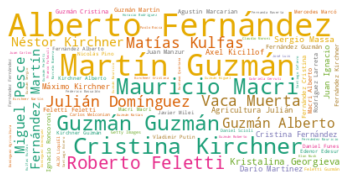

In [48]:
# Create and generate a word cloud image:
wc = WordCloud(background_color="white", colormap="Dark2",collocation_threshold=3,min_word_length=4,
                   max_font_size=150, random_state=42)

wordcloud = wc.generate(personas)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def crear_wordclouds(df):
    wc = WordCloud(background_color="white", colormap="Dark2",collocation_threshold=3,min_word_length=4,
                   max_font_size=150, random_state=42)

    plt.rcParams['figure.figsize'] = [20,15]

    sources = complete_df.source.unique().tolist()

    index = 0

    width = 4
    height = int(np.round(len(complete_df.source.unique()) / width,0))

    for source in sources:
        index += 1
        bag = df.text[df.source == source].str.cat(sep=' ')
        wc.generate(bag)
        plt.subplot(height, width, index)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(source)

    plt.show()
    
crear_wordclouds(complete_df)